In [2]:
import sys
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time
from math import *
from scipy import signal
import os
import warnings
import lalsimulation as lalsim
import emcee
import corner
import multiprocessing as mp
import matplotlib.patches as mpatches

# Initialize random number generator.
np.random.seed(12345)
%matplotlib inline

In [18]:
import sys
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time
from math import *
from scipy import signal
import os
import warnings

# Import other packages which are less common and specific to the task at hand.

import emcee
import corner
import multiprocessing as mp
import matplotlib.patches as mpatches

# Initialize random number generator.
np.random.seed(12345)

In [2]:
# Bunch of units

pc= 3.0856776*1e16
M_sun =1.9884099*1e30
Mpc = 10**6 * pc
GM_sun = 1.3271244*1e20
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
pi = np.pi
Mpc = 10**6 * pc


In [4]:
"""
Reference signal parameters
"""

# Fix these two impostors, assume they are known perfectly.
t0 =0.
phi0 =0.

# Find a resonable distance for the signal 

Deff = 10**3 *Mpc
logDeff = np.log(Deff)

beta_true = 5.0
eta_true = 0.2
mtot = 2*1e6 #in solar masses
Mchirp = mtot*(eta_true)**(3/5)
Mchirp_true =Mchirp* M_sun
logMchirp_true = np.log(Mchirp_true)

pars = [logMchirp_true,eta_true,beta_true] # array of parameters to sample through


In [5]:


"""
Frequency domain
"""
fmin =  0.0004
fmax =  c**3/(6*np.sqrt(6)*pi*G*Mchirp_true *eta_true**(-3/5))
t_year = 365*24*60*60       


T_obs = T_chirp(fmin,Mchirp_true,eta_true)  # Take signal in seconds.


delta_f =1/T_obs
freq = np.arange(fmin,fmax,delta_f)

print('df:', delta_f)
print('We observe for',
      np.round(T_obs,1),'s, ',
      np.round(12*30*T_obs/t_year,1),'days, ',
      np.round(T_obs/t_year,4),'yr')
print('fmin:', fmin)
print('fmax (chirp):', fmax)
print('Length of frequency array:', len(freq))



df: 9.275291599202399e-06
We observe for 107813.3 s,  1.2 days,  0.0034 yr
fmin: 0.0004
fmax (chirp): 0.0021985873919213874
Length of frequency array: 194


In [6]:
def PowerSpectralDensity(f):
    """
    @Ollie Burke
    
    Power Spectral Density for the LISA detector assuming it has been active for a year. 
    I found an analytic version in one of Niel Cornish's paper which he submitted to the arXiv in
    2018. I evaluate the PSD at the frequency bins found in the signal FFT.
    
    PSD obtained from: https://arxiv.org/pdf/1803.01944.pdf.
    Values chosen for confusion noise after 1 year of observation.
    
    """
    
    sky_averaging_constant = 1.0
    L = 2.5*10**9   # Length of LISA arm
    f0 = 19.09*10**(-3)    

    Poms = ((1.5e-11)*(1.5e-11))*(1 + np.power((2e-3)/f, 4))  # Optical Metrology Sensor
    Pacc = (3e-15)*(3e-15)* (1 + (4e-4/f)*(4e-4/f))*(1 + np.power(f/(8e-3),4 ))  # Acceleration Noise
    
    # Parameters for confusion noise after Tobs=1yr.
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    
    Sc = 0 # no confusion noise (non-stationary effect)
           # add it back here, in case.

    PSD = sky_averaging_constant* ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD

    return PSD


In [7]:
PSD = PowerSpectralDensity(freq)

noisevar = PSD/(4*delta_f)                   # Parseval's theorem
noisemean = 0.

In [8]:
# signals
h_true_vec_f = htilde(freq,pars)
data_f_vec = h_true_vec_f


In [9]:
def inner_prod(sig1_f,sig2_f,PSD,delta_f):
    """
    Only makes sense for continuous fourier transforms. (No dt's floating around). 
    This takes as input dimensionful quantities.
    """
    return (4*delta_f) * np.real(np.sum(np.conjugate(sig1_f)*sig2_f/PSD))

In [10]:
# SNR of the resolved source

SNR2 = inner_prod(data_f_vec,h_true_vec_f,PSD,delta_f) 
h_SNR2 = inner_prod(h_true_vec_f,h_true_vec_f,PSD,delta_f) 

rho = np.sqrt(SNR2)
print('Optimal SNR for the resolved source is',rho)

Optimal SNR for the resolved source is 16809.92617091844


In [11]:
# Priors on frequency
eta_low_range = 0.01  
eta_high_range = 0.25

# Priors on the phase
logMchirp_low_range = np.log(10*M_sun)
logMchirp_high_range = np.log(20000000*M_sun)

# Priors on spin parameters: check Berti, Buonanno, Will.

"""
Recall this is the full range of beta!
"""

beta_low = 0.00001
beta_high = 9.4

In [12]:
"""
Coded up by Ollie Burke.
"""

def lprior_eta(eta):


    if eta < eta_low_range or eta > eta_high_range: # are you out of your range?
        print('I am out of my range.')
        return -1e10 
    else:
        return np.log(1/(eta_high_range - eta_low_range))

def lprior_logMchirp(logMchirp):
    
    if logMchirp < logMchirp_low_range or logMchirp > logMchirp_high_range: # are you out of your range?
        print('I am out of my range.')
        return -1e10
    else:
        return np.log(1/(logMchirp_high_range - logMchirp_low_range))

def lprior_beta(beta):

    
    if beta < beta_low or beta > beta_high: # are you out of your range?
        print('I am out of my range.')
        return -1e10
    else:
        return np.log(1/(beta_high - beta_low))


In [13]:
def llike(params, data_f):
    print(params)
    """
    Assumption: Known PSD otherwise need additional term
    """
    signal_f = htilde(freq,params)
    return(-0.5 * np.sum((np.abs(data_f - signal_f)**2) / noisevar))

def lpost(params):
    '''
    Compute log posterior.
    Add parameters here as you see fit.
    Add if clauses for each prior
    '''
    data_f = data_f_vec
    logMchirp = params[0]
    eta = params[1]
    beta = params[2]
    
    if beta < beta_low or beta > beta_high or eta < eta_low_range or eta > eta_high_range or logMchirp < logMchirp_low_range or logMchirp > logMchirp_high_range:
        res = -np.inf
    else:
        res = llike(params, data_f) + lprior_logMchirp(params[0]) + lprior_eta(params[1])+lprior_beta(params[2])

    return res

In [14]:
iterations = 10000

pos = [logMchirp_true,eta_true,beta_true]

"""
Notice that here we start around the true values. In this sense we are
not perfoming a search, but merely checking Fisher estimates. Change the prefactor 
of the random number if you want to explore a bit more of the parameter space.
"""

start= pos*(1+1e-9* np.random.randn(6, 3))

# output
nwalkers, ndim = start.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost)
sampler.run_mcmc(start, iterations, progress=True)
flat_samples = sampler.get_chain(discard=1500, thin=1, flat=False)

100%|██████████| 10000/10000 [00:14<00:00, 689.34it/s]


In [15]:
"""
Gather all the relevant samples here. If you increase the dimensionality of 
the toy model or problem in general, add more dimensions here as well.
"""

# Stack the samples for the parameters sampled through. 
org_samp = np.vstack( (flat_samples[:,:,0].flatten(), #mass samples.
                       flat_samples[:,:,1].flatten(), #mass-ratios
                       flat_samples[:,:,2].flatten()  #spin samples.
                      ) ).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (51000, 3)
median =  [83.30788283  0.19999975  4.99999759]


In [16]:
# Nice plotting options for corner plots.

CORNER_KWARGS = dict(
    smooth=0.99, # smooths out contours. 
    plot_datapoints=False, # choose if you want datapoints
    label_kwargs=dict(fontsize=12.5), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=12.5), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=1, # set a limit to ticks in the x-y axes.
    title_fmt=".1e", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

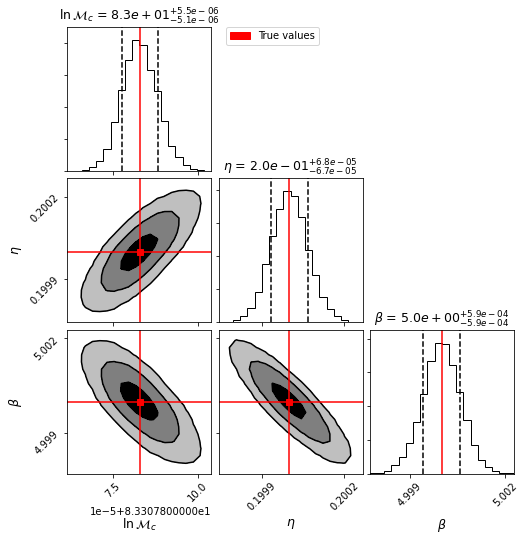

In [19]:
labels = [r'$\ln\mathcal{M}_c$', r'$\eta$', r'$\beta$']
truths=[logMchirp_true,eta_true,beta_true]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

red_patch = mpatches.Patch(color='red', label='True values')
plt.legend(handles=[red_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
plt.show()